# Importing packages

In [2]:
import pandas as pd
import seaborn as sns
import gpplot
import matplotlib.pyplot as plt
import numpy as np
sns.set_palette('Set2')
from poola import core as pool
import re
from functools import reduce
import requests, sys, os

# Importing files

Import Supplementary Table 1 containing read counts and guide annotations

In [6]:
guide_counts = pd.read_excel('/../../../Supplementary Data 1.xlsx', 
                             'Read counts', 
                             skiprows=3, names = ['Construct Barcode', 'pDNA', 'HT29_CD4_high_RDA682', 
                                                  'HT29_CD97_high_RDA682','HT29_CD4_CD97_low_RDA682',
                                                  'HT29_CD4_high_RDA683', 'HT29_CD97_high_RDA683',
                                                  'HT29_CD4_CD97_low_RDA683','HT29_CD274_high_RDA682', 
                                                  'HT29_CD274_low_RDA682','HT29_CD274_high_RDA683', 
                                                  'HT29_CD274_low_RDA683','A375_CD4_high_RDA682', 
                                                  'A375_CD4_low_RDA682','A375_CD4_high_RDA683', 
                                                  'A375_CD4_low_RDA683','A375_CD274_high_RDA682', 
                                                  'A375_CD26_high_RDA682','A375_CD274_CD26_low_RDA682',
                                                  'A375_CD274_high_RDA683','A375_CD26_high_RDA683',
                                                  'A375_CD274_CD26_low_RDA683'])
guide_counts.set_index('Construct Barcode',inplace=True)
annotation = pd.read_excel('/../../../Supplementary Data 1.xlsx', 
                           'Library annotation')
annotation.set_index('Construct Barcode',inplace=True)

In [7]:
#subsetting controls
ctrl_col = 'Target Gene Symbol'
ctrl_type = 'INTERGENIC|NO_SITE'
cas12_controls = list(annotation[annotation[ctrl_col].str.contains(ctrl_type)][ctrl_col])
print(len(cas12_controls))

600


In [8]:
cell_lines = ['A375','HT29']
replicates = ['RDA682','RDA683']
#RDA682 = dCas12a-VP64
#RDA683 = VP64-dCas12a-VP64
genes = ['CD4','CD274','CD26','CD97']

# Lognormalizing data

In [9]:
lognorms = pool.lognorm_columns(reads_df=guide_counts,columns=guide_counts.columns)
lognorms_count = lognorms.shape[0]
lognorms = pool.filter_pdna(lognorm_df=lognorms,pdna_cols=['pDNA'], z_low=-3)
filtered_lognorms_count = lognorms.shape[0]
print('Filtered ' + str(lognorms_count - filtered_lognorms_count) + ' columns due to low pDNA abundance')

Filtered 42 columns due to low pDNA abundance


# Calculating Log-2-fold Change

In [10]:
def get_low_bin(s):
    '''
    Gets column name with 'low' in name. This function is called in low_high_LFC.

    PARAMETERS
    ----------
    s: list of str, column names from which to extract low sample

    OUTPUTS
    -------
    str, column name
    '''    
    return [x for x in s if 'low' in x][0]

def get_high_bin(s):
    '''
    Gets column name with 'high' in name. This function is called in low_high_LFC.

    PARAMETERS
    ----------
    s: list of str, column names from which to extract low sample

    OUTPUTS
    -------
    str, column name 
    '''
    return [x for x in s if 'high' in x][0]


def calculate_LFC(lognorm_df,genes,cell_lines,replicates,direction):
    '''
    Calculates the LFC for each replicate, gene, cell line either low - high or high - low
    
    PARAMETERS
    ----------
    lognorm_df: dataframe containing lognorm values
    genes: list of genes found in column names
    cell_lines: list of cell line(s) screened/in column names
    replicates: list of replicate names
    direction: str, "high-low" or "low-high" to indicate LFC direction
    
    OUTPUTS
    -------
    dataframe containing LFC values
    '''   
    df = pd.DataFrame(index=lognorm_df.index)
    for c in cell_lines:
        for i,g in enumerate(genes):
            col = [x for x in lognorm_df.columns if c in x if g+"_" in x]
            if col: 
                for i,x in enumerate(replicates):
                    rep_cols = [x for x in col if replicates[i] in x]
                    df.loc[:,c+"_"+g+'_'+replicates[i]] = lognorm_df.loc[:,get_low_bin(rep_cols)] - lognorm_df.loc[:,get_high_bin(rep_cols)]
                    if (direction == 'low-high'):
                        print(get_low_bin(rep_cols) + ' - ' + get_high_bin(rep_cols))
                    elif (direction == 'high-low'):
                        df.loc[:,c+"_"+g+'_'+replicates[i]] = df.loc[:,c+"_"+g+'_'+replicates[i]].multiply(other=-1)
                        print(get_high_bin(rep_cols) + ' - ' + get_low_bin(rep_cols))
                    else:
                        print("Enter high-low or low-high for direction parameter")
                        return None                   
    return df

In [11]:
lfcs = calculate_LFC(lognorm_df=lognorms,
                                     genes=['CD4','CD97','CD274','CD26'],
                                     cell_lines=['A375','HT29'],
                                     replicates=['RDA682','RDA683'],
                                     direction='high-low')

A375_CD4_high_RDA682 - A375_CD4_low_RDA682
A375_CD4_high_RDA683 - A375_CD4_low_RDA683
A375_CD274_high_RDA682 - A375_CD274_CD26_low_RDA682
A375_CD274_high_RDA683 - A375_CD274_CD26_low_RDA683
A375_CD26_high_RDA682 - A375_CD274_CD26_low_RDA682
A375_CD26_high_RDA683 - A375_CD274_CD26_low_RDA683
HT29_CD4_high_RDA682 - HT29_CD4_CD97_low_RDA682
HT29_CD4_high_RDA683 - HT29_CD4_CD97_low_RDA683
HT29_CD97_high_RDA682 - HT29_CD4_CD97_low_RDA682
HT29_CD97_high_RDA683 - HT29_CD4_CD97_low_RDA683
HT29_CD274_high_RDA682 - HT29_CD274_low_RDA682
HT29_CD274_high_RDA683 - HT29_CD274_low_RDA683


In [12]:
lfcs = annotation.merge(lfcs, on = 'Construct Barcode')

# Plotting replicate correlations

In [13]:
def assign_category(r,gene):
    if r == gene:
        return gene
    elif 'ESSENTIAL' in r:
        return 'splice control'
    elif 'INTERGENIC' in r:
        return 'intergenic control'
    elif 'NO_SITE' in r:
        return 'non-targeting'
    else:
        return 'other'

In [14]:
palette = {
    'splice control': 'grey',
    'intergenic control':'black',
    'non-targeting': 'black',
    'other': 'grey'
}
gene_list = list(lfcs['Target Gene Symbol'])
gene_list = set([x for x in gene_list if ('ESSENTIAL' not in x) and ('NO_SITE' not in x) and ('ONE' not in x)])

for g in gene_list:
    palette[g] = sns.color_palette('Set2')[0]

In [15]:
# Function definition
# explicitly add enrichment_df as an input parameter for my_plot_enrich function
def my_plot_enrich(cell_line, gene, df): 
    # Remove any duplicated columns
    #enrichment_df = enrichment_df.copy().loc[:,~enrichment_df.columns.duplicated()]
    new_df = df.copy()
    for i,r in new_df.iterrows():
        new_df.loc[i,gene+'_Category'] = assign_category(r['Target Gene Symbol'],gene)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.scatterplot(data=new_df,x=cell_line +"_"+ gene +'_RDA682', y=cell_line +"_"+ gene +'_RDA683', 
                    hue=gene+'_Category', palette=palette, edgecolor = None);
    gpplot.add_correlation(data=new_df, x=cell_line +"_"+ gene +'_RDA682', y=cell_line +"_"+ gene +'_RDA683')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
    plt.xlim(-15,15)
    plt.ylim(-15,15)
    plt.xticks(np.arange(-10,15,5));
    plt.yticks(np.arange(-10,15,5));
    #plt.savefig("../../Individual Panels/"+cell_line + ' '+gene+' rep correlations.pdf', dpi=1000,bbox_inches = 'tight')

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


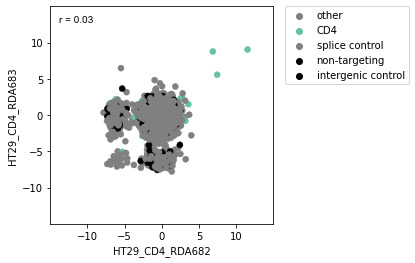

In [16]:
my_plot_enrich('HT29', 'CD4', lfcs)

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


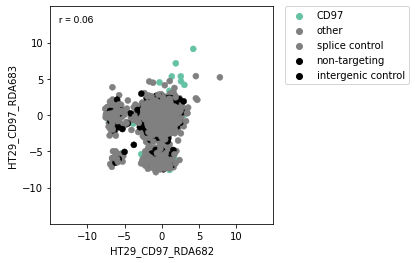

In [17]:
my_plot_enrich('HT29', 'CD97', lfcs)

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


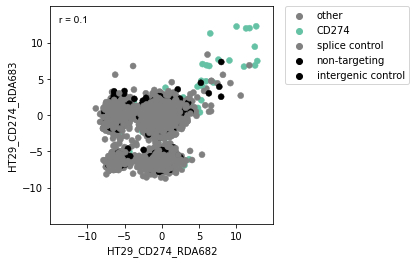

In [18]:
my_plot_enrich('HT29', 'CD274', lfcs)

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


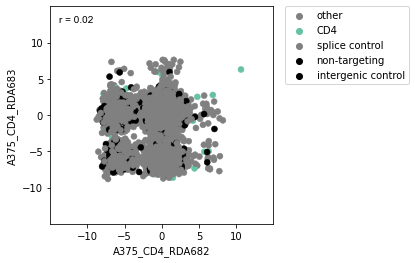

In [19]:
my_plot_enrich('A375', 'CD4', lfcs)

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


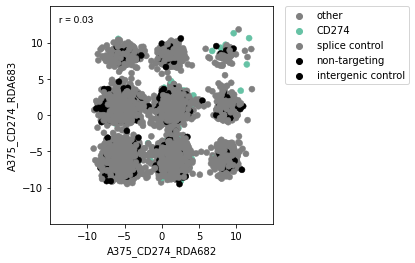

In [20]:
my_plot_enrich('A375', 'CD274', lfcs)

/Users/fzheng/opt/anaconda3/lib/python3.8/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


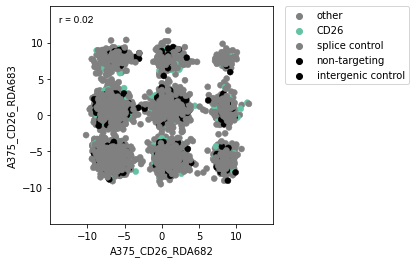

In [21]:
my_plot_enrich('A375', 'CD26', lfcs)

# Z-scoring LFC values

In [22]:
'''
Calculates the z-score of specific columns (cols) using a given list of controls (controls) which are annotated
in the given column (ctrl_col) of the input data set. Returns the resulting dataframe.
'''                
def get_z_score(data,cols,ctrl_col,controls):
    new_df = pd.DataFrame()
    for c in cols:
        mean = data.loc[data[ctrl_col].isin(controls),c].mean()
        std = data.loc[data[ctrl_col].isin(controls),c].std()
        new_df.loc[:,c] = data.loc[:,c].apply(lambda x: (x-mean)/std)
    return new_df

In [28]:
zscores = get_z_score(data = lfcs, cols = lfcs.columns[3:],
                                   ctrl_col = 'Target Gene Symbol',
                                   controls = cas12_controls)

In [29]:
zscores

,A375_CD4_RDA682,A375_CD4_RDA683,A375_CD274_RDA682,A375_CD274_RDA683,A375_CD26_RDA682,A375_CD26_RDA683,HT29_CD4_RDA682,HT29_CD4_RDA683,HT29_CD97_RDA682,HT29_CD97_RDA683,HT29_CD274_RDA682,HT29_CD274_RDA683
Construct Barcode,,,,,,,,,,,,
AAAAACCCTCTGCTAGAGTTTCC,0.496444,0.641403,0.911387,0.850522,0.505569,0.620760,-0.165018,0.998921,0.072063,2.660241,0.093362,0.616545
AAAACACAGACCCAGGGGCGCTG,0.231622,0.549480,0.673653,0.707400,0.438669,0.255497,0.502519,0.482277,0.132279,0.772488,1.154610,-1.746440
AAAACCCTCTGCTAGAGTTTCCA,-1.530825,0.599411,-0.735466,0.695763,-1.076398,2.123475,0.260633,0.286726,0.594932,0.429065,0.954294,0.093052
AAAGCAGCATCCGTGGTGTCCAA,0.707970,-1.273180,0.662725,0.438545,0.505569,0.427725,0.242977,-0.545219,1.365402,0.407605,0.333034,0.411099
AAAGCAGGTTGCACTTCATTCTT,-1.181117,0.692591,-0.603693,-0.884189,-0.914774,-0.706668,-3.095429,1.081446,1.916731,3.094664,0.651617,-1.639028
...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGCCTTCGCCTCGCCCGCAGC,0.353346,1.070959,1.109965,-0.732029,-0.748589,0.716978,0.218843,0.195884,0.454177,0.240157,0.682075,0.141370
TTGGTAAGTATCCCTTTCATTAG,0.760792,0.594908,-0.856752,0.534073,-1.122520,-1.109139,0.607336,0.147185,0.436869,0.484664,0.107321,0.058580
TTGTAGTTGGGGCCCAGAGAGAT,0.211294,0.255005,-0.770785,-0.997694,-0.626073,-1.090387,0.424298,0.592131,0.916451,-0.024455,0.139827,-0.064742


In [30]:
cell_lines

['A375', 'HT29']

In [32]:


re.compile('A375'+".*"+'CD4'+"_.*")

re.compile(r'A375.*CD4_.*', re.UNICODE)

In [84]:
'''
Calculates the minimum z-score for each gene, cell line replicate as noted by the screen_info dictionary.

'''   
def get_min_zscore(zscore_df,genes,cell_lines):
    new_df = pd.DataFrame()
    for c in cell_lines:
        for g in genes:
            r = re.compile(c+".*"+g+"_.*")
            col = list(filter(r.match, zscore_df.columns))
            if col:
                new_df[c+"_"+g] = zscore_df[col[0]].where(zscore_df[col[0]].abs() < zscore_df[col[1]].abs(), zscore_df[col[1]])
    return new_df


In [85]:
min_zscores = get_min_zscore_var(zscores,genes,cell_lines)
min_zscores

['A375_CD4_RDA682', 'A375_CD4_RDA683']
['A375_CD274_RDA682', 'A375_CD274_RDA683']
['A375_CD26_RDA682', 'A375_CD26_RDA683']
[]
['HT29_CD4_RDA682', 'HT29_CD4_RDA683']
['HT29_CD274_RDA682', 'HT29_CD274_RDA683']
[]
['HT29_CD97_RDA682', 'HT29_CD97_RDA683']


,A375_CD4,A375_CD274,A375_CD26,HT29_CD4,HT29_CD274,HT29_CD97
Construct Barcode,,,,,,
AAAAACCCTCTGCTAGAGTTTCC,0.496444,0.850522,0.505569,-0.165018,0.093362,0.072063
AAAACACAGACCCAGGGGCGCTG,0.231622,0.673653,0.255497,0.482277,1.154610,0.132279
AAAACCCTCTGCTAGAGTTTCCA,0.599411,0.695763,-1.076398,0.260633,0.093052,0.429065
AAAGCAGCATCCGTGGTGTCCAA,0.707970,0.438545,0.427725,0.242977,0.333034,0.407605
AAAGCAGGTTGCACTTCATTCTT,0.692591,-0.603693,-0.706668,1.081446,0.651617,1.916731
...,...,...,...,...,...,...
TTGGCCTTCGCCTCGCCCGCAGC,0.353346,-0.732029,0.716978,0.195884,0.141370,0.240157
TTGGTAAGTATCCCTTTCATTAG,0.594908,0.534073,-1.109139,0.147185,0.058580,0.436869
TTGTAGTTGGGGCCCAGAGAGAT,0.211294,-0.770785,-0.626073,0.424298,-0.064742,-0.024455


In [86]:
min_zscores = annotation.merge(min_zscores, on = 'Construct Barcode')

In [87]:
min_zscores_HT29 = min_zscores[['Target Gene Symbol','Technology',
                                "sgRNA 'Cut' Site TSS Offset",'HT29_CD4', 'HT29_CD274','HT29_CD97']]
min_zscores_HT29.rename(columns = {'HT29_CD4':'CD4','HT29_CD274':'CD274','HT29_CD97':'CD97'}, inplace= True)
min_zscores_HT29['Cell line'] = 'HT29'

min_zscores_A375 = min_zscores[['Target Gene Symbol','Technology',
                                "sgRNA 'Cut' Site TSS Offset",'A375_CD4', 'A375_CD274', 'A375_CD26']]
min_zscores_A375.rename(columns = {'A375_CD4':'CD4','A375_CD274':'CD274','A375_CD26':'CD26'}, inplace = True)
min_zscores_A375['Cell line'] = 'A375'

min_zscores_concat = pd.concat([min_zscores_HT29,min_zscores_A375])

/var/folders/h4/ryygmkjj3m32xw7cjfk2gbvr0000gq/T/ipykernel_7314/23820469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_zscores_HT29.rename(columns = {'HT29_CD4':'CD4','HT29_CD274':'CD274','HT29_CD97':'CD97'}, inplace= True)
/var/folders/h4/ryygmkjj3m32xw7cjfk2gbvr0000gq/T/ipykernel_7314/23820469.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_zscores_HT29['Cell line'] = 'HT29'
/var/folders/h4/ryygmkjj3m32xw7cjfk2gbvr0000gq/T/ipykernel_7314/23820469.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame



# Generating positional-based plots

In [105]:
#modified to take more than one cell line as input
def plot_tss(df, gene): 
    for i,r in df.iterrows():
        df.loc[i,gene+'_Category'] = assign_category(r['Target Gene Symbol'],gene)
    ycol = gene
    fig, ax = plt.subplots(figsize=(4.5,4))
    sns.scatterplot(data=df[df['Target Gene Symbol'] == gene ], 
                    x="sgRNA 'Cut' Site TSS Offset", 
                    y=ycol, hue = 'Cell line', edgecolor = "none", legend= True);
    plt.legend(loc="upper right")

    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.axhline(0, ls='-', color = "black")
    plt.ylim(-5, 7.5)
    ax.set_yticks([-5,-2.5,0,2.5,5,7.5])
    ax.set_xticks([-300,-150,0,150,300])
    #ax.set_yticks([])
    #ax.tick_params(left=False)
    #plt.xlabel("Position Relative to TSS") 
    ax.set(xlabel=None)
    ax.set(ylabel=None)
    plt.suptitle(gene)
    #plt.ylabel('Minimum z-scored LFC (sorted for ' + gene + ')')
    #plt.savefig(""+ gene + ' TSS annotated zscores.pdf', dpi=300,bbox_inches = 'tight')
    

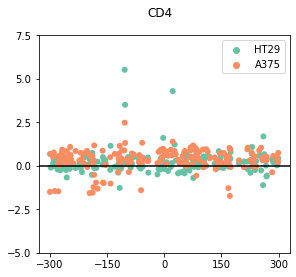

In [106]:
plot_tss(min_zscores_concat, 'CD4')

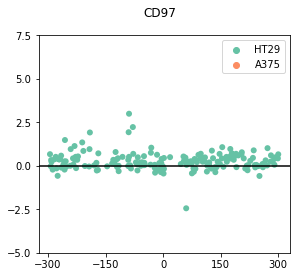

In [107]:
plot_tss(min_zscores_concat, 'CD97')

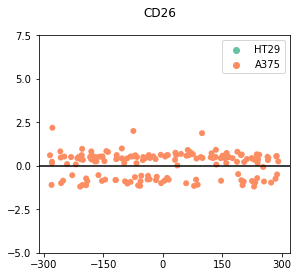

In [108]:
plot_tss(min_zscores_concat, 'CD26')

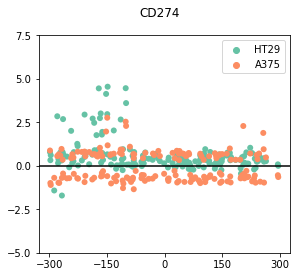

In [109]:
plot_tss(min_zscores_concat, 'CD274')